# Hack with Parallel Corpus


Hi everyone!

My name is Alex Shonenkov, recently I have created two kernels with my ideas about this competition: [[TPU-Inference] Super Fast XLMRoberta](https://www.kaggle.com/shonenkov/tpu-inference-super-fast-xlmroberta) and [NLP Albumentations](https://www.kaggle.com/shonenkov/nlp-albumentations).

I am very impressive after some discussions that we could find common ground!
It very charges for me, thank you all, my friends!

Today I would like to share with you dataset and simple intresting approach for hacking language difficulties due to given competition data doesn't have samples for other languages.

I want to tell you about [Parallel Corpus](https://en.wikipedia.org/wiki/Parallel_text) and about how we can get new toxic samples on other languages.


## MAIN IDEA

In the past in these competitions [Jigsaw Unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification) and [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) we (Kaggle Community) created good models for English language with ~99% AUC score.

Also I would like to say thanks a lot [OpenSubtitles Community](https://www.opensubtitles.org/) for opportunities using their [datasets](http://opus.nlpl.eu/OpenSubtitles-v2018.php).
Datasets have others formats but I used .txt format. It is two files on two languages, each of them has text splitted by line.


So, main idea: lets load corpus `en <--> other_lang`, make prediction toxic for english language and match these toxic labels with some thresholds for samples in the second file that has another language! (Pseudo-Labeling)


P.S. First of all I used google to know information about using "Mashine Translation" for creating their datasets and I found information about OpenSubtitles Community [fighting](https://forum.opensubtitles.org/viewtopic.php?f=1&t=1969#p6752) with loaded subtitles created by "Mashine Translation"

### Implementation of this technique

This Corpus is very huge, but I would like to make demo on small corpus :)

In [1]:
!pip install transformers > /dev/null
!pip install pandarallel > /dev/null

In [2]:
import numpy as np
import pandas as pd

import os
os.environ['XLA_USE_BF16'] = "1"

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler

import time
import random
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

from transformers import XLMRobertaModel, XLMRobertaTokenizer, XLMRobertaConfig
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule

import re

# !pip install nltk > /dev/null
import nltk
nltk.download('punkt')

from nltk import sent_tokenize

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=2, progress_bar=True)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
!wget -O en-ru.txt.zip http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-ru.txt.zip
!unzip en-ru.txt.zip
!rm en-ru.txt.zip
!rm OpenSubtitles.en-ru.ids

--2020-04-28 19:00:00--  http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-ru.txt.zip
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-ru.txt.zip [following]
--2020-04-28 19:00:01--  https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-ru.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 872700441 (832M) [application/zip]
Saving to: ‘en-ru.txt.zip’

en-ru.txt.zip       100%[===================>] 832.27M  76.6MB/s    in 11s     

2020-04-28 19:00:12 (74.3 MB/s) - ‘en-ru.txt.zip’ saved [872700441/872700441]

Archive:  en-ru.txt.zip
  inflating: OpenSubtitles.en-ru.en  
  inflating: OpenSub

In [4]:
!head -10 OpenSubtitles.en-ru.en

Kids can get pretty much anything they want in the yard, as long as they can afford it.
'Cause everything comes with a price.
Hey, Nick.
Do you know anyone who's got any strawberry milk?
Hey, do we know anyone who has strawberry milk?
Yeah, I think Donnie's got some.
Donnie Freckles?
No, Donnie the Mexican.
Good, 'cause I'm really jonesing for some.
You think he'll trade for these?


In [5]:
!head -10 OpenSubtitles.en-ru.ru

Дети могут достать во дворе почти всё что угодно до тех пор, пока могут себе это позволить.
Всё имеет свою цену.
Эй, Ник.
У кого-нибудь есть клубничное молоко?
Мы знаем, у кого есть клубничное молоко?
Да, думаю у Донни немножко есть.
У Донни Фреклса?
Нет, Донни-мексиканца.
Отлично, так сильно хочется.
Думаешь он сможет поменяться на это?


So, above you can see EN and RU first 10 lines. I am from Russia so I can say that it is correct translation for my language. You can try another language if you want. 

In [6]:
ru_file = open('./OpenSubtitles.en-ru.ru', 'r')
en_file = open('./OpenSubtitles.en-ru.en', 'r')

dataset = {'en': [],'ru': []}

total_lines = 10000
for i in tqdm(range(total_lines), total=total_lines):
    ru_text = ru_file.readline()
    en_text = en_file.readline()

    if not en_text and not ru_text:
        # one of file is finished
        break

    ru_text = ru_text.strip()
    en_text = en_text.strip()
    if not en_text or not ru_text:
        continue

    dataset['ru'].append(ru_text)
    dataset['en'].append(en_text)
    
ru_file, en_file = None, None

del ru_file
del en_file

df = pd.DataFrame(dataset)
df.head()

100%|██████████| 10000/10000 [00:00<00:00, 376569.28it/s]


,en,ru
0,Kids can get pretty much anything they want in...,Дети могут достать во дворе почти всё что угод...
1,'Cause everything comes with a price.,Всё имеет свою цену.
2,"Hey, Nick.","Эй, Ник."
3,Do you know anyone who's got any strawberry milk?,У кого-нибудь есть клубничное молоко?
4,"Hey, do we know anyone who has strawberry milk?","Мы знаем, у кого есть клубничное молоко?"


### Language detection

I observed not only chosen language in samples. So I recommend do checking lang. For example using [SpaCY](https://spacy.io/usage/models) with multilang model. But this is not necessary.

In [7]:
!pip install spacy > /dev/null
!pip install spacy_cld > /dev/null
!python -m spacy download xx_ent_wiki_sm > /dev/null

import spacy
from spacy_cld import LanguageDetector
import xx_ent_wiki_sm

nlp = xx_ent_wiki_sm.load()
language_detector = LanguageDetector()
nlp.add_pipe(language_detector)

In [8]:
def get_lang_score(text):
    try:
        doc = nlp(str(text))
        language_scores = doc._.language_scores
        return language_scores.get('ru', 0)
    except Exception:
        return 0

text = df.iloc[0]['ru']
print(f'[{get_lang_score(text)}]', text)

[0.99] Дети могут достать во дворе почти всё что угодно до тех пор, пока могут себе это позволить.


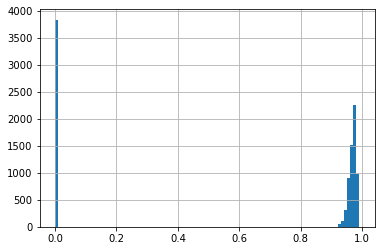

In [9]:
df['lang_score'] = df['ru'].parallel_apply(get_lang_score)
df['lang_score'].hist(bins=100)

In [10]:
df = df[df['lang_score'] > 0.8]

Here I recommend you use good model for strong single English language with good accuracy. But It is only demo, so I can relax :D Let me use model from [my kernel](https://www.kaggle.com/shonenkov/tpu-inference-super-fast-xlmroberta), for example using GPU.

In [11]:
MAX_LENGTH = 224
BACKBONE_PATH = '../input/multitpu-inference'
CHECKPOINT_PATH = '../input/multitpu-inference/checkpoint-xlm-roberta.bin'

LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

def get_sentences(text, lang='en'):
    return sent_tokenize(text, LANGS.get(lang, 'english'))

def exclude_duplicate_sentences(text, lang='en'):
    sentences = []
    for sentence in get_sentences(text, lang):
        sentence = sentence.strip()
        if sentence not in sentences:
            sentences.append(sentence)
    return ' '.join(sentences)

def clean_text(text, lang='en'):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = exclude_duplicate_sentences(text, lang)
    return text.strip()

In [12]:
class DatasetRetriever(Dataset):

    def __init__(self, df):
        self.comment_texts = df['en'].values
        self.ids = df.index.values
        self.tokenizer = XLMRobertaTokenizer.from_pretrained(BACKBONE_PATH)

    def get_tokens(self, text):
        encoded = self.tokenizer.encode_plus(
            text, 
            add_special_tokens=True, 
            max_length=MAX_LENGTH, 
            pad_to_max_length=True
        )
        return encoded['input_ids'], encoded['attention_mask']

    def __len__(self):
        return self.ids.shape[0]

    def __getitem__(self, idx):
        text = self.comment_texts[idx]

        tokens, attention_mask = self.get_tokens(text)
        tokens, attention_mask = torch.tensor(tokens), torch.tensor(attention_mask)

        return self.ids[idx], tokens, attention_mask

In [13]:
%%time

df['en'] = df.parallel_apply(lambda x: clean_text(x['en'], 'en'), axis=1)
df = df.drop_duplicates(subset='en')
df = df.drop_duplicates(subset='ru')

CPU times: user 120 ms, sys: 46.4 ms, total: 167 ms
Wall time: 555 ms


In [14]:
class ToxicSimpleNNModel(nn.Module):

    def __init__(self, backbone):
        super(ToxicSimpleNNModel, self).__init__()
        self.backbone = backbone
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(
            in_features=self.backbone.pooler.dense.out_features*2,
            out_features=2,
        )

    def forward(self, input_ids, attention_masks):
        bs, seq_length = input_ids.shape
        seq_x, _ = self.backbone(input_ids=input_ids, attention_mask=attention_masks)
        apool = torch.mean(seq_x, 1)
        mpool, _ = torch.max(seq_x, 1)
        x = torch.cat((apool, mpool), 1)
        x = self.dropout(x)
        return self.linear(x)


backbone = XLMRobertaModel(XLMRobertaConfig.from_pretrained(BACKBONE_PATH))

In [15]:
class GPUPredictor:
    
    def __init__(self, model):
        self.device = torch.device('cuda:0')
        self.model = model.to(self.device)

    def run_inference(self, loader):
        self.model.eval()
        result = {'id': [], 'toxic': []}
        for step, (ids, inputs, attention_masks) in tqdm(enumerate(loader), total=len(loader)):
            with torch.no_grad():
                inputs = inputs.to(self.device) 
                attention_masks = attention_masks.to(self.device)
                outputs = self.model(inputs, attention_masks)
                toxics = nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,1]

            result['id'].extend(ids.numpy())
            result['toxic'].extend(toxics)

        return pd.DataFrame(result)

In [16]:
net = ToxicSimpleNNModel(backbone=backbone)
checkpoint = torch.load(CHECKPOINT_PATH)
net.load_state_dict(checkpoint);

checkpoint = None
del checkpoint

In [17]:
dataset = DatasetRetriever(df)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    sampler=SequentialSampler(dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2
)

predictor = GPUPredictor(net)

In [18]:
predictions = predictor.run_inference(loader)
predictions = predictions.set_index('id')

100%|██████████| 366/366 [02:03<00:00,  2.97it/s]


### Attention!
Thresholds I recommend choose on your validation set for English model! It is very important.  

In [19]:
df.loc[predictions.index, 'toxic'] = predictions['toxic']
df = df[(df['toxic'] > 0.9) | (df['toxic'] < 0.2)]
df.loc[:, 'toxic'] = df['toxic'].round().astype(int)
df['toxic'].value_counts()

0    5418
1      85
Name: toxic, dtype: int64

So, lets see on toxic samples:

In [20]:
for _, row in df[df['toxic'] == 1].head(10).iterrows():
    print('-'*10)
    print('[EN]')
    print(row['en'])
    print('[RU]')
    print(row['ru'])

----------
[EN]
Here you go. Now get the fuck out of here, you junkie.
[RU]
А теперь нафиг иди отсюда, нарик.
----------
[EN]
He gives his shit away for free.
[RU]
Он раздаёт своё дерьмо на халяву.
----------
[EN]
It's a big fucking setback to lose a member of my crew, so I paid off Patti to hook a patsy from Nick's crew.
[RU]
Потеря члена банды охренительно тормозит бизнес. Пришлось заплатить Патси, чтобы завербовать придурка Ника.
----------
[EN]
I'm so frickin' screwed!
[RU]
Я так тупо попался! Почему ты так говоришь?
----------
[EN]
But this tampon shit, it's not so fucking funny.
[RU]
Но эта хрень с тампонами ни фига не смешная.
----------
[EN]
I mean, whatever floats your boat, but he's gotta get rid of that frickin' magic shit, because, bitch, he'll get caught before he gets into junior high, 'cause this shit's
[RU]
Иначе, сука, схватят его ещё до средней школы. Мир жесток к таким как он.
----------
[EN]
Tell him he's my best worker, and ask him what the fucking problem is.
[RU]

### Smoothing


So, you can create your own pseudo-labeled multilingual toxic dataset. But how we can guarantee about correctness of marking!?

I'm in a hurry to upset you: no way.

So I strongly recommend use label smoothing if you train on pseudo-labeled data.

If you don't know about label smoothing you should [read this](https://www.flixstock.com/label-smoothing-an-ingredient-of-higher-model-accuracy/)


![](https://miro.medium.com/proxy/1*BQosKd3FHZWsfKRF6pdVtQ.png)


## Thank you for reading my kernel!

Let's go make high scoring solutions!


P.S. Next my kernel will be about my training pipeline :)